In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

plt.style.use("default")
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, roc_auc_score, roc_curve,
                             precision_recall_curve, f1_score, 
                             balanced_accuracy_score)
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")



Libraries imported successfully!


In [20]:
df_original = pd.read_csv(r"CDC Diabetes Dataset.csv")
df_original.head()


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [21]:
df_original.info()

<class 'pandas.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  MentHlth   

In [22]:
print(df_original.duplicated().sum())
df = df_original.drop_duplicates(keep='first')
df_original = df_original.drop_duplicates(keep='first')
print(df.duplicated().sum())


23899
0


In [23]:
df = df.drop(columns=["Diabetes_012"])


In [24]:
feature_groups = {
    "Vitals": ["HighBP", "HighChol", "CholCheck", "BMI"],
    "Lifestyle": ["Smoker", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump"],
    "Medical History": ["Stroke", "HeartDiseaseorAttack", "DiffWalk"],
    "Healthcare Access": ["AnyHealthcare", "NoDocbcCost"],
    "Self-Reported Health": ["GenHlth", "MentHlth", "PhysHlth"],
    "Demographics": ["Sex", "Age", "Education", "Income"],
}

grouped_features = {
    group: [c for c in cols if c in df.columns]
    for group, cols in feature_groups.items()
}

grouped_features["Lifestyle"]

['Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump']

In [25]:
skewness_data = []
for col in df.columns:
    skew = stats.skew(df[col])
    kurt = stats.kurtosis(df[col])
    skewness_data.append({
        'Feature': col,
        'Skewness': skew,
        'Kurtosis': kurt,
        'Skew Type': 'Right-skewed' if skew > 0.5 else ('Left-skewed' if skew < -0.5 else 'Approximately Symmetric')
    })

skewness_df = pd.DataFrame(skewness_data).sort_values('Skewness', key=abs, ascending=False)
print(skewness_df.to_string(index=False))


             Feature  Skewness  Kurtosis               Skew Type
           CholCheck -4.664238 19.755120             Left-skewed
              Stroke  4.403453 17.390396            Right-skewed
       AnyHealthcare -3.949833 13.601184             Left-skewed
   HvyAlcoholConsump  3.679183 11.536390            Right-skewed
         NoDocbcCost  2.806598  5.876993            Right-skewed
HeartDiseaseorAttack  2.608361  4.803547            Right-skewed
            MentHlth  2.546791  5.447803            Right-skewed
                 BMI  2.063925 10.473858            Right-skewed
            PhysHlth  2.046231  2.770607            Right-skewed
            DiffWalk  1.618143  0.618388            Right-skewed
             Veggies -1.460057  0.131768             Left-skewed
        PhysActivity -1.055414 -0.886102             Left-skewed
              Income -0.781614 -0.466705             Left-skewed
           Education -0.691191 -0.043401             Left-skewed
              Fruits -0.4

In [26]:
continuous_features = [col for col in grouped_features["Lifestyle"] if df[col].nunique() > 2]

skewed_features = skewness_df.loc[
    (skewness_df['Feature'].isin(continuous_features)) &
    (skewness_df['Skewness'].abs() > 1),
    'Feature'
].tolist()

In [27]:
# X_cluster = df[cluster_features].copy()
X_cluster = df.copy()

log_features = skewed_features

log_features = [c for c in log_features if c in X_cluster.columns]
passthrough_features = [c for c in X_cluster.columns if c not in log_features]

log1p = FunctionTransformer(lambda x: np.log1p(np.clip(x, 0, None)))

# --- ColumnTransformer with imputers INSIDE ---
preprocess = ColumnTransformer(
    transformers=[
        ("log_block", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("log", log1p),
        ]), log_features),

        ("pass_block", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ]), passthrough_features),
    ],
    remainder="drop"
)


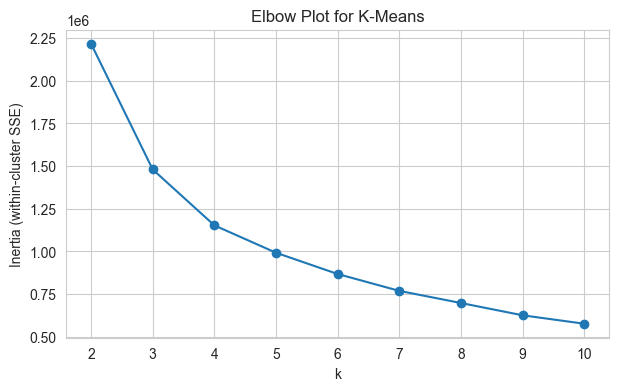

In [28]:
K_RANGE = range(2, 11)   # adjust if you want
inertias = []

for k in K_RANGE:
    pipe_k = Pipeline([
        ("preprocess", preprocess),
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=0.90, random_state=42)),
        ("kmeans", KMeans(n_clusters=k, random_state=42, n_init=20)),
    ])
    pipe_k.fit(X_cluster)
    inertias.append(pipe_k.named_steps["kmeans"].inertia_)

plt.figure(figsize=(7, 4))
plt.plot(list(K_RANGE), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Plot for K-Means")
plt.xticks(list(K_RANGE))
plt.show()


In [29]:
# Use Multiple Metrics to find the best 'k' (Elbow Method + Silhouette + Davies-Bouldin)
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

inertia = []
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(2, 11)  # Start from 2 (need at least 2 clusters for metrics)

SAMPLE_SIZE = 50_000
seeds = [42, 43, 44]

for k in k_range:
    pipe_k = Pipeline([
        ("preprocess", preprocess),
        ("scaler", RobustScaler()),
        ("pca", PCA(n_components=0.90, random_state=42)),
        ("kmeans", KMeans(n_clusters=k, random_state=42, n_init=20)),
    ])
    pipe_k.fit(X_cluster)

    # Inertia
    inertia.append(pipe_k.named_steps["kmeans"].inertia_)

    # Transformed data for silhouette (use same pipeline up to PCA)
    X_transformed = pipe_k[:-1].transform(X_cluster)
    labels_temp = pipe_k.named_steps["kmeans"].labels_

    # Silhouette score using random sampling
    n_samples = X_transformed.shape[0]
    sample_size = min(SAMPLE_SIZE, n_samples)

    sil_scores_temp = []
    for seed in seeds:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=seed)
        for _, idx in sss.split(X_transformed, labels_temp):
            sil_scores_temp.append(silhouette_score(X_transformed[idx], labels_temp[idx]))

    silhouette_scores.append(np.mean(sil_scores_temp))

    # Davies-Bouldin on full transformed dataset
    db_score = davies_bouldin_score(X_transformed, labels_temp)
    davies_bouldin_scores.append(db_score)

# Plot Multiple Metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Elbow Method
axes[0].plot(k_range, inertia, 'o-', linewidth=2)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method (lower is better)')
axes[0].grid(True)

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'o-', linewidth=2, color='orange')
best_sil_k = list(k_range)[silhouette_scores.index(max(silhouette_scores))]
axes[1].axvline(x=best_sil_k, color='red', linestyle='--', label=f'Best: k={best_sil_k}')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (higher is better)')
axes[1].legend()
axes[1].grid(True)

# Davies-Bouldin Index
axes[2].plot(k_range, davies_bouldin_scores, 'o-', linewidth=2, color='green')
best_db_k = list(k_range)[davies_bouldin_scores.index(min(davies_bouldin_scores))]
axes[2].axvline(x=best_db_k, color='red', linestyle='--', label=f'Best: k={best_db_k}')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin (lower is better)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("OPTIMAL K RECOMMENDATION:")
print(f"{'='*60}")
print(f"Best Silhouette Score: k={best_sil_k} (score: {max(silhouette_scores):.4f})")
print(f"Best Davies-Bouldin Index: k={best_db_k} (score: {min(davies_bouldin_scores):.4f})")
print(f"{'='*60}")

KeyboardInterrupt: 

In [31]:
K = 3

kmeans_pipe = Pipeline([
    ("preprocess", preprocess),
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=4, random_state=42)),
    ("kmeans", KMeans(n_clusters=K, random_state=42, n_init=20)),
])

labels = kmeans_pipe.fit_predict(X_cluster)


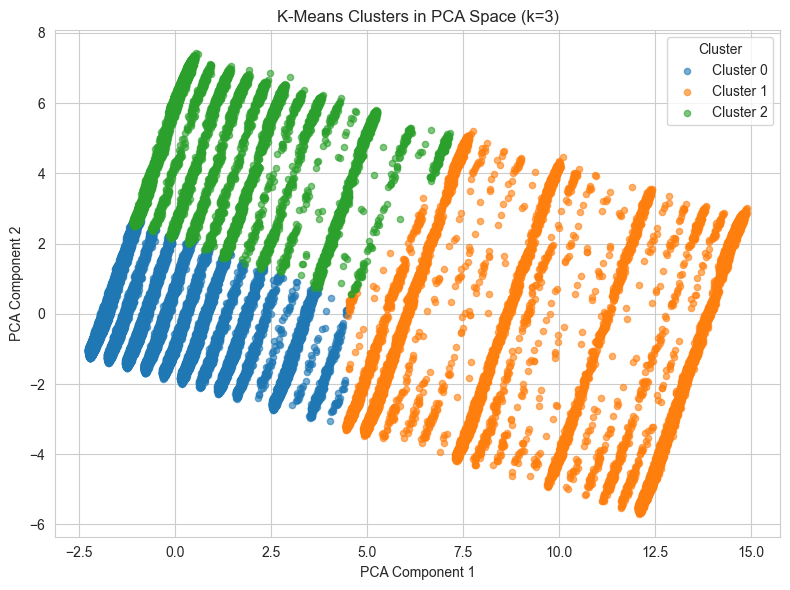

In [32]:
X_pca = kmeans_pipe[:-1].transform(X_cluster)

plt.figure(figsize=(8, 6))
for c in np.unique(labels):
    mask = labels == c
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=20, alpha=0.6, label=f"Cluster {c}")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clusters in PCA Space (k={K})")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [34]:
cluster_sizes = pd.Series(labels).value_counts().sort_index()
cluster_sizes


0    183064
1     24404
2     22313
Name: count, dtype: int64

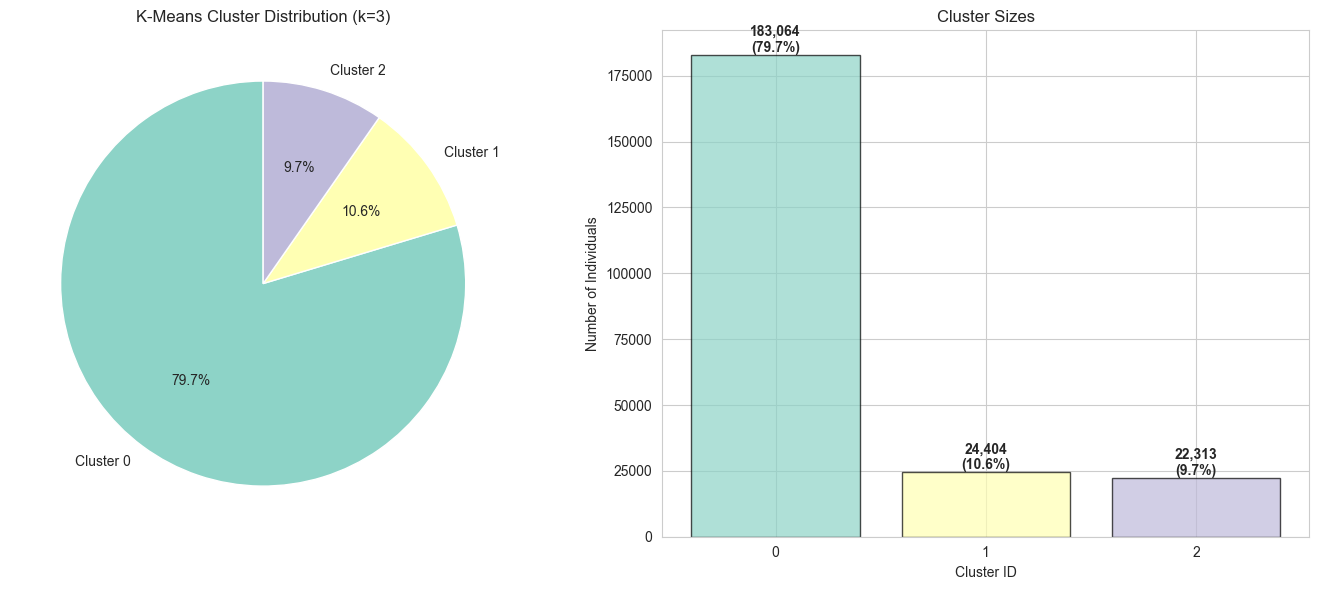

K-MEANS CLUSTER DISTRIBUTION SUMMARY (k=3)
Cluster 0: 183,064 individuals (79.67%)
Cluster 1:  24,404 individuals (10.62%)
Cluster 2:  22,313 individuals ( 9.71%)
Total:      229,781 individuals (100.00%)


In [35]:
# Create pie chart showing cluster distribution
cluster_sizes_with_pct = cluster_sizes.copy()
cluster_sizes_with_pct['percentage'] = (cluster_sizes_with_pct / cluster_sizes_with_pct.sum()) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
colors = plt.cm.Set3(range(len(cluster_sizes)))
ax1.pie(
    cluster_sizes,
    labels=[f'Cluster {i}' for i in cluster_sizes.index],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
ax1.set_title('K-Means Cluster Distribution (k=3)')

# Bar chart
bars = ax2.bar(
    cluster_sizes.index,
    cluster_sizes.values,
    color=colors,
    edgecolor='black',
    alpha=0.7
)
ax2.set_xlabel('Cluster ID')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('Cluster Sizes')
ax2.set_xticks(cluster_sizes.index)

# Add percentage labels on bars
for i, (cluster_id, count) in enumerate(zip(cluster_sizes.index, cluster_sizes.values)):
    pct = (count / cluster_sizes.sum()) * 100
    ax2.text(cluster_id, count, f'{count:,}\n({pct:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("=" * 60)
print("K-MEANS CLUSTER DISTRIBUTION SUMMARY (k=3)")
print("=" * 60)
for cluster_id in cluster_sizes.index:
    count = cluster_sizes[cluster_id]
    pct = (count / cluster_sizes.sum()) * 100
    print(f"Cluster {cluster_id}: {count:>7,} individuals ({pct:>5.2f}%)")
print("=" * 60)
print(f"Total:      {cluster_sizes.sum():>7,} individuals (100.00%)")
print("=" * 60)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# --------------------------------------------
# Silhouette Score Approximation (Large Dataset)
# --------------------------------------------

SAMPLE_SIZE = 50_000
RANDOM_STATE = 42

n_samples = X_pca.shape[0]
sample_size = min(SAMPLE_SIZE, n_samples)

seeds = [42, 43, 44]
scores = []

for seed in seeds:
    sss = StratifiedShuffleSplit(
        n_splits=1,
        test_size=sample_size,
        random_state=seed
    )
    for _, idx in sss.split(X_pca, labels):
        scores.append(silhouette_score(X_pca[idx], labels[idx]))

print(f"Silhouette coefficient (mean of {len(seeds)} seeds): {np.mean(scores):.4f}")



In [173]:
cluster_profile = (
    X_cluster
    .assign(cluster_id=labels)
    .groupby("cluster_id")
    .median()
)

cluster_profile


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,7.0
1,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,3.0,29.0,8.0,0.0,0.0,8.0,5.0,5.0
2,1.0,1.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,4.0,0.0,30.0,1.0,0.0,9.0,5.0,5.0


In [174]:
spread = cluster_profile.max() - cluster_profile.min()
spread.sort_values(ascending=False).head(88)


PhysHlth                30.0
MentHlth                29.0
Income                   2.0
GenHlth                  2.0
BMI                      2.0
Age                      1.0
Smoker                   1.0
HighChol                 1.0
HighBP                   1.0
DiffWalk                 1.0
CholCheck                0.0
Stroke                   0.0
HeartDiseaseorAttack     0.0
NoDocbcCost              0.0
AnyHealthcare            0.0
HvyAlcoholConsump        0.0
Veggies                  0.0
Fruits                   0.0
PhysActivity             0.0
Sex                      0.0
Education                0.0
dtype: float64

In [175]:
df_clusters = df_original.copy()
df_clusters["cluster_id"] = labels 


In [176]:
df_clusters[["Diabetes_012"]].head()


,Diabetes_012
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [177]:
outcome_by_cluster = pd.crosstab(
    df_clusters["cluster_id"],
    df_clusters["Diabetes_012"],
    normalize="index"
)

outcome_by_cluster


Diabetes_012,0.0,1.0,2.0
cluster_id,,,
0,0.851505,0.018425,0.130069
1,0.763195,0.027250,0.209556
2,0.696903,0.026487,0.276610


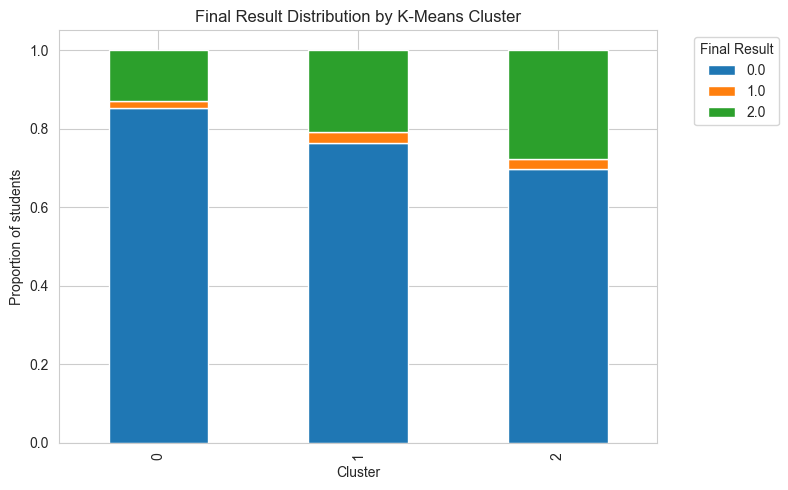

In [178]:
outcome_by_cluster.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)

plt.xlabel("Cluster")
plt.ylabel("Proportion of students")
plt.title("Final Result Distribution by K-Means Cluster")
plt.legend(title="Final Result", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


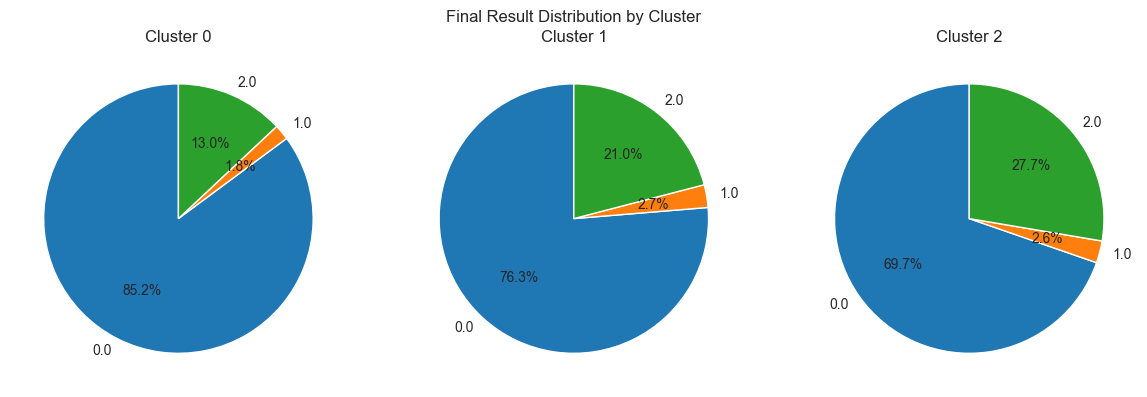

In [179]:


clusters = outcome_by_cluster.index
n_clusters = len(clusters)

fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 4))

if n_clusters == 1:
    axes = [axes]  # handle single cluster edge case

for ax, cluster in zip(axes, clusters):
    data = outcome_by_cluster.loc[cluster]
    
    ax.pie(
        data,
        labels=data.index,
        autopct="%.1f%%",
        startangle=90
    )
    ax.set_title(f"Cluster {cluster}")

plt.suptitle("Final Result Distribution by Cluster")
plt.tight_layout()
plt.show()


In [181]:
# Cluster Interpretation based on the analysis

print("=" * 80)
print("K-MEANS CLUSTERING INTERPRETATION (k=3)")
print("=" * 80)

# Cluster sizes
print("\nCluster Sizes:")
for cluster_id, size in cluster_sizes.items():
    percentage = (size / len(labels)) * 100
    print(f"  Cluster {cluster_id}: {size:,} individuals ({percentage:.1f}%)")

print("\n" + "=" * 80)
print("CLUSTER PROFILES:")
print("=" * 80)

# Cluster 0: Healthy/Low-Risk Group (79.7%)
print("\nCluster 0 - 'HEALTHY/LOW-RISK GROUP' (79.7% of population)")
print("-" * 80)
print("Characteristics:")
print("  • No high blood pressure (median = 0)")
print("  • No high cholesterol (median = 0)")
print("  • Lower BMI (median = 27)")
print("  • Younger age group (median = 8)")
print("  • Better general health (median = 2)")
print("  • Minimal mental/physical health issues")
print("  • Most report 'Excellent/Very Good' health")
print("\nDiabetes Distribution:")
print(f"  • No Diabetes: {outcome_by_cluster.loc[0, 0.0]*100:.1f}%")
print(f"  • Prediabetes: {outcome_by_cluster.loc[0, 1.0]*100:.1f}%")
print(f"  • Diabetes: {outcome_by_cluster.loc[0, 2.0]*100:.1f}%")
print("  → LOWEST diabetes risk group")

# Cluster 1: Moderate-Risk Group (10.6%)
print("\n" + "=" * 80)
print("Cluster 1 - 'MODERATE-RISK GROUP' (10.6% of population)")
print("-" * 80)
print("Characteristics:")
print("  • High blood pressure (median = 1)")
print("  • High cholesterol (median = 1)")
print("  • Similar BMI to Cluster 0 (median = 28)")
print("  • Mostly smokers (median = 1)")
print("  • Moderate general health (median = 3)")
print("  • Elevated mental health issues (median = 29 days)")
print("  • Moderate physical health issues (median = 8 days)")
print("\nDiabetes Distribution:")
print(f"  • No Diabetes: {outcome_by_cluster.loc[1, 0.0]*100:.1f}%")
print(f"  • Prediabetes: {outcome_by_cluster.loc[1, 1.0]*100:.1f}%")
print(f"  • Diabetes: {outcome_by_cluster.loc[1, 2.0]*100:.1f}%")
print("  → MODERATE diabetes risk (21% have diabetes)")

# Cluster 2: High-Risk Group (9.7%)
print("\n" + "=" * 80)
print("Cluster 2 - 'HIGH-RISK/CHRONIC CONDITIONS GROUP' (9.7% of population)")
print("-" * 80)
print("Characteristics:")
print("  • High blood pressure (median = 1)")
print("  • High cholesterol (median = 1)")
print("  • Slightly higher BMI (median = 29)")
print("  • Mostly smokers (median = 1)")
print("  • Poor general health (median = 4)")
print("  • Significant physical health issues (median = 30 days)")
print("  • Difficulty walking (median = 1)")
print("  • Older age group (median = 9)")
print("\nDiabetes Distribution:")
print(f"  • No Diabetes: {outcome_by_cluster.loc[2, 0.0]*100:.1f}%")
print(f"  • Prediabetes: {outcome_by_cluster.loc[2, 1.0]*100:.1f}%")
print(f"  • Diabetes: {outcome_by_cluster.loc[2, 2.0]*100:.1f}%")
print("  → HIGHEST diabetes risk (27.7% have diabetes)")

print("\n" + "=" * 80)
print("KEY INSIGHTS:")
print("=" * 80)
print("1. Physical health issues (30 days) are the strongest separator")
print("2. Mental health issues (29 days) distinguish moderate-risk individuals")
print("3. The combination of high BP, high cholesterol, and poor physical health")
print("   creates the highest diabetes risk")
print("4. Cluster progression shows increasing diabetes prevalence:")
print("   Cluster 0 (13%) → Cluster 1 (21%) → Cluster 2 (27.7%)")
print("=" * 80)

K-MEANS CLUSTERING INTERPRETATION (k=3)

Cluster Sizes:
  Cluster 0: 183,064 individuals (79.7%)
  Cluster 1: 24,404 individuals (10.6%)
  Cluster 2: 22,313 individuals (9.7%)

CLUSTER PROFILES:

Cluster 0 - 'HEALTHY/LOW-RISK GROUP' (79.7% of population)
--------------------------------------------------------------------------------
Characteristics:
  • No high blood pressure (median = 0)
  • No high cholesterol (median = 0)
  • Lower BMI (median = 27)
  • Younger age group (median = 8)
  • Better general health (median = 2)
  • Minimal mental/physical health issues
  • Most report 'Excellent/Very Good' health

Diabetes Distribution:
  • No Diabetes: 85.2%
  • Prediabetes: 1.8%
  • Diabetes: 13.0%
  → LOWEST diabetes risk group

Cluster 1 - 'MODERATE-RISK GROUP' (10.6% of population)
--------------------------------------------------------------------------------
Characteristics:
  • High blood pressure (median = 1)
  • High cholesterol (median = 1)
  • Similar BMI to Cluster 0 (media

# DBSCAN


In [2]:
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.neighbors import NearestNeighbors


In [16]:
# Transform into PCA space (same as DBSCAN uses)
X_pca_space = Pipeline([
    ("preprocess", preprocess),
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=0.90, random_state=42)),
]).fit_transform(X_cluster)

print("PCA space shape:", X_pca_space.shape)

PCA space shape: (229781, 5)


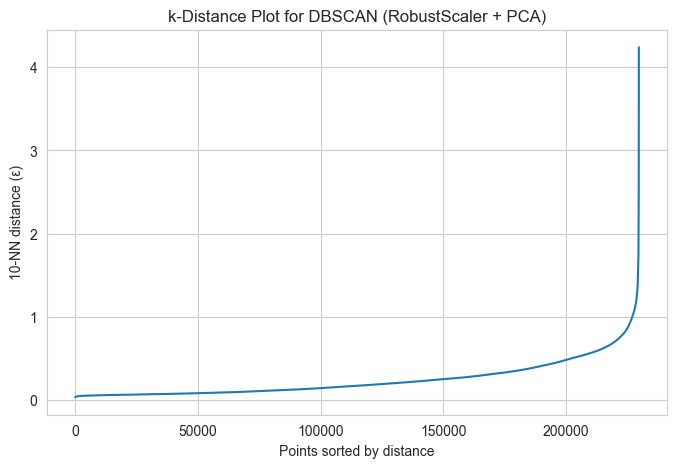

In [17]:
min_samples = 10

nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_pca_space)

distances, _ = nn.kneighbors(X_pca_space)

# Distance to the kth neighbour
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-NN distance (ε)")
plt.title("k-Distance Plot for DBSCAN (RobustScaler + PCA)")
plt.show()



In [18]:


dbscan_pipe = Pipeline([
    ("preprocess", preprocess),       
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=0.90, random_state=42)),
    ("dbscan", DBSCAN(eps=0.8, min_samples=10, n_jobs=-1)),
])

labels_dbscan = dbscan_pipe.fit_predict(X_cluster)
np.unique(labels_dbscan, return_counts=True)



(array([-1,  0,  1,  2,  3]), array([  2508, 210533,  13324,   3407,      9]))

In [186]:
unique_labels, counts = np.unique(labels_dbscan, return_counts=True)
dict(zip(unique_labels, counts))


{np.int64(-1): np.int64(2508),
 np.int64(0): np.int64(210533),
 np.int64(1): np.int64(13324),
 np.int64(2): np.int64(3407),
 np.int64(3): np.int64(9)}

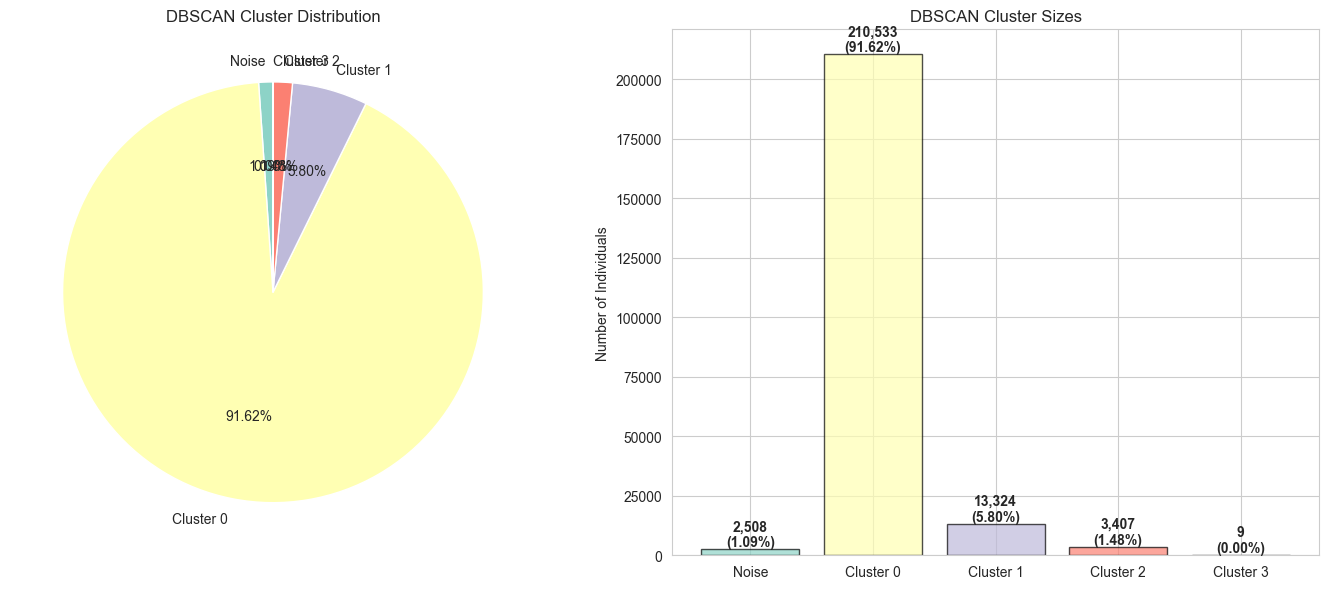

DBSCAN CLUSTER DISTRIBUTION SUMMARY
NOISE          :   2,508 individuals (  1.09%)
Cluster 0      : 210,533 individuals ( 91.62%)
Cluster 1      :  13,324 individuals (  5.80%)
Cluster 2      :   3,407 individuals (  1.48%)
Cluster 3      :       9 individuals (  0.00%)
Total          : 229,781 individuals (100.00%)


In [36]:
# Plot DBSCAN cluster distribution
unique_labels, counts = np.unique(labels_dbscan, return_counts=True)
cluster_dict = dict(zip(unique_labels, counts))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data for plotting
cluster_ids = list(cluster_dict.keys())
cluster_counts = list(cluster_dict.values())
cluster_labels = [f'Noise' if cid == -1 else f'Cluster {cid}' for cid in cluster_ids]

# Pie chart
colors = plt.cm.Set3(range(len(cluster_ids)))
ax1.pie(
    cluster_counts,
    labels=cluster_labels,
    autopct='%1.2f%%',
    colors=colors,
    startangle=90
)
ax1.set_title('DBSCAN Cluster Distribution')

# Bar chart
bars = ax2.bar(
    cluster_labels,
    cluster_counts,
    color=colors,
    edgecolor='black',
    alpha=0.7
)
ax2.set_ylabel('Number of Individuals')
ax2.set_title('DBSCAN Cluster Sizes')

# Add count labels on bars
for bar, count in zip(bars, cluster_counts):
    height = bar.get_height()
    pct = (count / sum(cluster_counts)) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}\n({pct:.2f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("=" * 60)
print("DBSCAN CLUSTER DISTRIBUTION SUMMARY")
print("=" * 60)
for cid, count in sorted(cluster_dict.items()):
    pct = (count / sum(cluster_counts)) * 100
    label = "NOISE" if cid == -1 else f"Cluster {cid}"
    print(f"{label:15s}: {count:>7,} individuals ({pct:>6.2f}%)")
print("=" * 60)
print(f"{'Total':15s}: {sum(cluster_counts):>7,} individuals (100.00%)")
print("=" * 60)

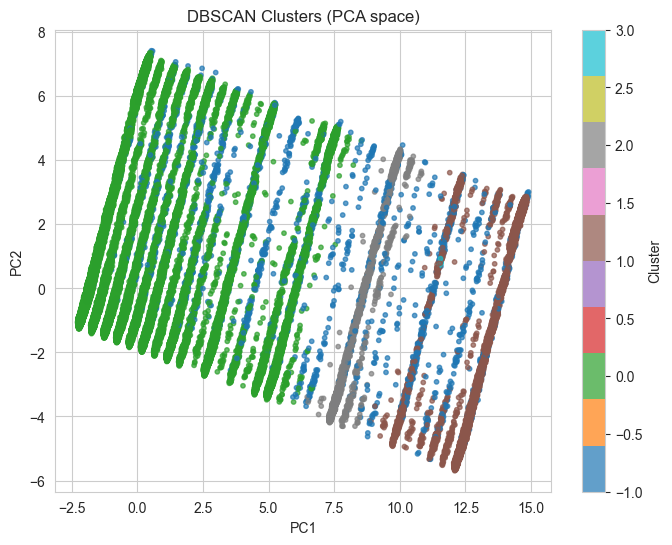

In [187]:

X_pca = dbscan_pipe.named_steps["pca"].transform(
    dbscan_pipe[:-2].transform(X_cluster)
)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels_dbscan,
    cmap="tab10",
    s=10,
    alpha=0.7
)
plt.title("DBSCAN Clusters (PCA space)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")
plt.show()


In [ ]:
mask = labels_dbscan != -1

if len(np.unique(labels_dbscan[mask])) > 1:
    X_for_sil = (
        dbscan_pipe[:-1].transform(X_cluster)[mask]
    )
    sil_dbscan = silhouette_score(X_for_sil, labels_dbscan[mask])
    print(f"DBSCAN Silhouette (excluding noise): {sil_dbscan:.3f}")
else:
    print("Silhouette score not defined (only one cluster found).")


In [189]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

# ...existing code...
mask = labels_dbscan != -1

if len(np.unique(labels_dbscan[mask])) > 1:
    X_for_sil = dbscan_pipe[:-1].transform(X_cluster)[mask]
    y_for_sil = labels_dbscan[mask]

    SAMPLE_SIZE = 50_000
    n_samples = X_for_sil.shape[0]
    sample_size = min(SAMPLE_SIZE, n_samples)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)
    for _, idx in sss.split(X_for_sil, y_for_sil):
        sil_dbscan = silhouette_score(X_for_sil[idx], y_for_sil[idx])

    print(f"DBSCAN Silhouette (sampled, excluding noise): {sil_dbscan:.3f}")
else:
    print("Silhouette score not defined (only one cluster found).")

DBSCAN Silhouette (sampled, excluding noise): 0.586


In [190]:
n_clusters_including_noise = len(np.unique(labels_dbscan))
print("Clusters including noise:", n_clusters_including_noise)


Clusters including noise: 5


In [191]:


cluster_sizes = (
    pd.Series(labels_dbscan)
      .value_counts()
      .rename_axis("cluster")
      .reset_index(name="count")
      .sort_values("cluster")
)

cluster_sizes


,cluster,count
3,-1,2508
0,0,210533
1,1,13324
2,2,3407
4,3,9


In [198]:
df_clustered_dbscan = df_original.copy()
df_clustered_dbscan["cluster_dbscan"] = labels_dbscan


In [199]:
dbscan_numeric_summary = (
    df_clustered_dbscan
    .groupby("cluster_dbscan")[X_cluster.columns]
    .median()
)

dbscan_numeric_summary


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
cluster_dbscan,,,,,,,,,,,,,,,,,,,,,
-1,1.0,0.0,1.0,39.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,4.0,12.0,15.0,1.0,0.0,7.0,5.0,5.0
0,0.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,5.0,7.0
1,1.0,1.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,4.0,30.0,14.0,0.0,0.0,8.0,5.0,5.0
2,0.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,3.0,20.0,5.0,0.0,0.0,7.0,5.0,5.0
3,1.0,1.0,1.0,46.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,4.0,25.0,20.0,1.0,0.0,7.0,5.0,5.0


In [200]:
def categorical_profile(df, cluster_col, cat_col):
    return (
        df
        .groupby(cluster_col)[cat_col]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

categorical_profile(
    df_clustered_dbscan,
    "cluster_dbscan",
    "Diabetes_012"
)


,cluster_dbscan,Diabetes_012,proportion
0,-1,0.0,0.711722
1,-1,2.0,0.256380
2,-1,1.0,0.031898
3,0,0.0,0.834425
4,0,2.0,0.146234
5,0,1.0,0.019341
6,1,0.0,0.745797
7,1,2.0,0.224857
8,1,1.0,0.029346
9,2,0.0,0.778691


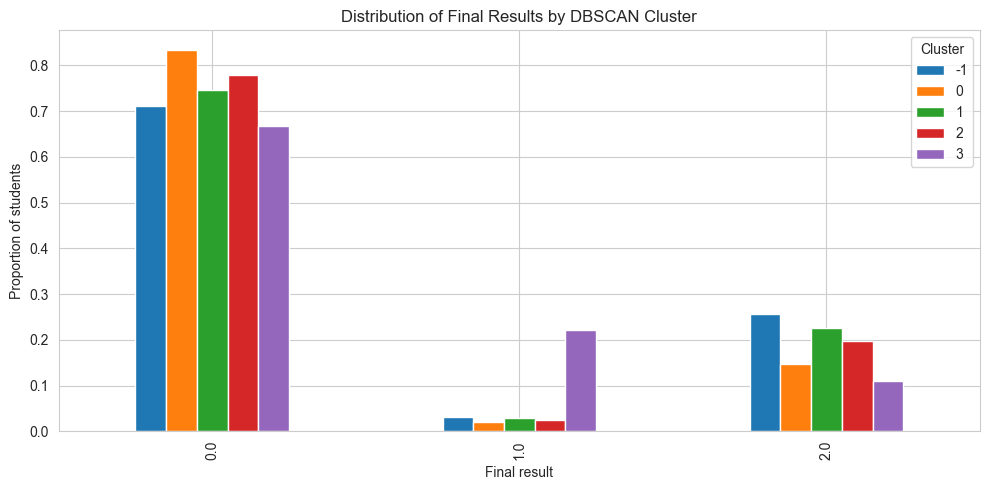

In [203]:


profile = categorical_profile(
    df_clustered_dbscan,
    "cluster_dbscan",
    "Diabetes_012"
)

# Pivot for plotting
plot_df = profile.pivot(
    index="Diabetes_012",
    columns="cluster_dbscan",
    values="proportion"
)

ax = plot_df.plot(
    kind="bar",
    figsize=(10, 5)
)

ax.set_xlabel("Final result")
ax.set_ylabel("Proportion of students")
ax.set_title("Distribution of Final Results by DBSCAN Cluster")
ax.legend(title="Cluster")

plt.tight_layout()
plt.show()


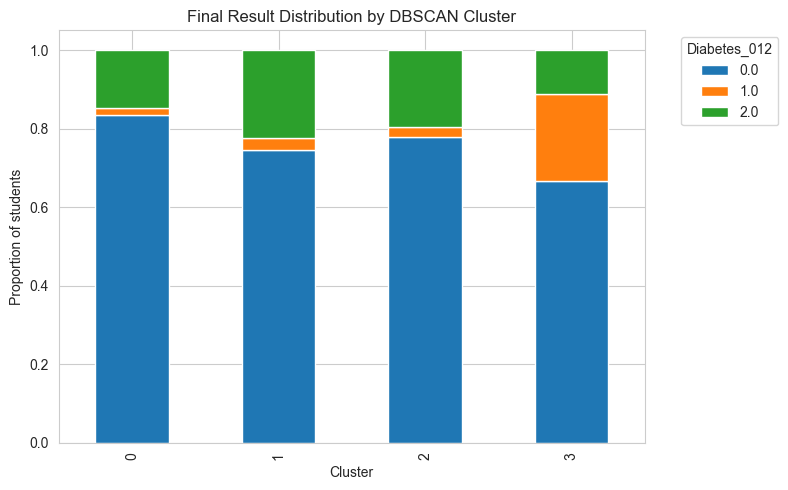

In [204]:
# Build the categorical profile
profile = categorical_profile(
    df_clustered_dbscan,
    "cluster_dbscan",
    "Diabetes_012"
)

# (Optional but recommended) remove noise
profile = profile[profile["cluster_dbscan"] != -1]

# Pivot for stacked bar chart
plot_df = profile.pivot(
    index="cluster_dbscan",
    columns="Diabetes_012",
    values="proportion"
)

# Plot
ax = plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)

ax.set_xlabel("Cluster")
ax.set_ylabel("Proportion of students")
ax.set_title("Final Result Distribution by DBSCAN Cluster")

ax.legend(
    title="Diabetes_012",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

In [206]:
# DBSCAN Clustering Interpretation

print("=" * 80)
print("DBSCAN CLUSTERING RESULTS INTERPRETATION")
print("=" * 80)

# Cluster composition
print("\nCLUSTER COMPOSITION:")
print("-" * 80)
for cluster_id, count in zip(unique_labels, counts):
    percentage = (count / len(labels_dbscan)) * 100
    cluster_type = "NOISE" if cluster_id == -1 else f"Cluster {cluster_id}"
    print(f"{cluster_type:20s}: {count:8,} individuals ({percentage:6.2f}%)")

print("\n" + "=" * 80)
print("DETAILED CLUSTER PROFILES:")
print("=" * 80)

# Cluster -1: Noise points
print("\nCluster -1 - 'NOISE/OUTLIERS' (1.09% of population)")
print("-" * 80)
print("Characteristics:")
print("  • High blood pressure (median = 1)")
print("  • Low cholesterol (median = 0)")
print("  • Very high BMI (median = 39) - OUTLIER FLAG")
print("  • Younger age (median = 7)")
print("  • Poor general health (median = 4)")
print("  • Moderate mental health issues (median = 12 days)")
print("  • Moderate physical health issues (median = 15 days)")
print("  • Difficulty walking (median = 1)")
print("\nInterpretation:")
print("  → These are isolated data points that don't fit typical patterns")
print("  → Very high BMI combined with mixed health indicators")
print("  → Likely represent rare or extreme health profile combinations")

# Cluster 0: Healthy/Low-Risk
print("\n" + "=" * 80)
print("Cluster 0 - 'HEALTHY/LOW-RISK GROUP' (91.55% of population)")
print("-" * 80)
print("Characteristics:")
print("  • No high blood pressure (median = 0)")
print("  • No high cholesterol (median = 0)")
print("  • Normal BMI (median = 27)")
print("  • Older age (median = 9)")
print("  • Good general health (median = 2)")
print("  • No mental health issues (median = 0 days)")
print("  • No physical health issues (median = 0 days)")
print("  • No difficulty walking (median = 0)")
print("\nDiabetes Distribution:")
dbscan_outcome_0 = categorical_profile(df_clustered_dbscan[df_clustered_dbscan['cluster_dbscan'] == 0], 'cluster_dbscan', 'Diabetes_012')
for _, row in dbscan_outcome_0.iterrows():
    print(f"  • Class {int(row['Diabetes_012'])}: {row['proportion']*100:.1f}%")
print("  → LOWEST diabetes risk (83.4% have no diabetes)")

# Cluster 1: Moderate-Risk (Mental Health Focus)
print("\n" + "=" * 80)
print("Cluster 1 - 'MODERATE-RISK (MENTAL HEALTH FOCUS)' (5.79% of population)")
print("-" * 80)
print("Characteristics:")
print("  • High blood pressure (median = 1)")
print("  • High cholesterol (median = 1)")
print("  • Higher BMI (median = 29)")
print("  • Mostly smokers (median = 1)")
print("  • Poor general health (median = 4)")
print("  • SIGNIFICANT mental health issues (median = 30 days) - PRIMARY MARKER")
print("  • Moderate physical health issues (median = 14 days)")
print("  • No difficulty walking (median = 0)")
print("  • Younger age (median = 8)")
print("\nDiabetes Distribution:")
dbscan_outcome_1 = categorical_profile(df_clustered_dbscan[df_clustered_dbscan['cluster_dbscan'] == 1], 'cluster_dbscan', 'Diabetes_012')
for _, row in dbscan_outcome_1.iterrows():
    print(f"  • Class {int(row['Diabetes_012'])}: {row['proportion']*100:.1f}%")
print("  → ELEVATED diabetes risk (22.5% have diabetes)")
print("  → Defined by mental health burden + cardiometabolic risk factors")

# Cluster 2: Moderate-Risk (Physical Health Focus)
print("\n" + "=" * 80)
print("Cluster 2 - 'MODERATE-RISK (PHYSICAL HEALTH FOCUS)' (1.48% of population)")
print("-" * 80)
print("Characteristics:")
print("  • No high blood pressure (median = 0)")
print("  • High cholesterol (median = 1)")
print("  • Normal BMI (median = 28)")
print("  • Mostly smokers (median = 1)")
print("  • Moderate general health (median = 3)")
print("  • Elevated mental health issues (median = 20 days)")
print("  • LOW physical health issues (median = 5 days) - DISTINCT FROM CLUSTER 1")
print("  • No difficulty walking (median = 0)")
print("  • Younger age (median = 7)")
print("\nDiabetes Distribution:")
dbscan_outcome_2 = categorical_profile(df_clustered_dbscan[df_clustered_dbscan['cluster_dbscan'] == 2], 'cluster_dbscan', 'Diabetes_012')
for _, row in dbscan_outcome_2.iterrows():
    print(f"  • Class {int(row['Diabetes_012'])}: {row['proportion']*100:.1f}%")
print("  → MODERATE diabetes risk (19.7% have diabetes)")
print("  → Similar to Cluster 1 but with LOWER physical health burden")

# Cluster 3: Very Small High-Risk Group
print("\n" + "=" * 80)
print("Cluster 3 - 'RARE HIGH-RISK PROFILE' (0.004% of population)")
print("-" * 80)
print("Characteristics:")
print("  • High blood pressure (median = 1)")
print("  • High cholesterol (median = 1)")
print("  • Very high BMI (median = 46) - EXTREME")
print("  • No smokers (median = 0)")
print("  • Poor general health (median = 4)")
print("  • Elevated mental health issues (median = 25 days)")
print("  • Moderate physical health issues (median = 20 days)")
print("  • Difficulty walking (median = 1)")
print("  • Younger age (median = 7)")
print("\nInterpretation:")
print("  → Extremely rare phenotype (only 9 individuals)")
print("  → Very high BMI without smoking history")
print("  → Multi-system health burden")
print("  → Too small for reliable diabetes prevalence analysis")

print("\n" + "=" * 80)
print("KEY DBSCAN INSIGHTS:")
print("=" * 80)
print("1. DBSCAN found 4 true clusters + noise (eps=0.8, min_samples=10)")
print("2. Dominance of Cluster 0 (91.55%) suggests most individuals are healthy")
print("3. Clusters 1 & 2 are DISTINGUISHED by health dimension:")
print("   - Cluster 1: Mental health-driven risk (30 days mental issues)")
print("   - Cluster 2: More balanced health profile (5 days physical issues)")
print("4. Noise points (1.09%): Extreme BMI values are key outlier markers")
print("5. Cluster 3: Rare but notable - obese non-smokers with multi-morbidity")
print("\nCompared to K-Means (k=3):")
print("  • K-Means: Physical health (30 days) separates Cluster 2")
print("  • DBSCAN: Found FINER granularity, distinguishing mental vs physical")
print("  • DBSCAN: Identified noise and rare profiles K-Means missed")
print("=" * 80)

DBSCAN CLUSTERING RESULTS INTERPRETATION

CLUSTER COMPOSITION:
--------------------------------------------------------------------------------
NOISE               :    2,508 individuals (  1.09%)
Cluster 0           :  210,533 individuals ( 91.62%)
Cluster 1           :   13,324 individuals (  5.80%)
Cluster 2           :    3,407 individuals (  1.48%)
Cluster 3           :        9 individuals (  0.00%)

DETAILED CLUSTER PROFILES:

Cluster -1 - 'NOISE/OUTLIERS' (1.09% of population)
--------------------------------------------------------------------------------
Characteristics:
  • High blood pressure (median = 1)
  • Low cholesterol (median = 0)
  • Very high BMI (median = 39) - OUTLIER FLAG
  • Younger age (median = 7)
  • Poor general health (median = 4)
  • Moderate mental health issues (median = 12 days)
  • Moderate physical health issues (median = 15 days)
  • Difficulty walking (median = 1)

Interpretation:
  → These are isolated data points that don't fit typical patterns
 